# 다중선형회귀 + 학습성능 개선

> 농어의 무게 예측 데이터 셋

텐서플로우의 학습성능을 개선하기 위해 아래의 기능을 사용할 수 있음

- 데이터 표준화: 학습률 향상에 도움을 줌
- 콜백함수: 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 설정 하기 위한 도구

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 학습에 대한 콜백함수 참조
import keras
from tensorflow.python.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터셋 준비하기

In [2]:
origin = my_read_excel('https://data.hossam.kr/mldata/fish.xlsx', info=False)


상위 5개 행
+----+--------+--------+--------+--------+
|    |   길이 |   높이 |   두께 |   무게 |
|----+--------+--------+--------+--------|
|  0 |    8.4 |   2.11 |   1.41 |    5.9 |
|  1 |   13.7 |   3.53 |      2 |     32 |
|  2 |     15 |   3.82 |   2.43 |     40 |
|  3 |   16.2 |   4.59 |   2.63 |   51.5 |
|  4 |   17.4 |   4.59 |   2.94 |     70 |
+----+--------+--------+--------+--------+


## #02. 데이터 전처리

### [1] 훈련/검증 데이터 분리

**데이터 정규화(스케일링)** 을 수행함

데이터에 정규화 처리를 적용하면 쉽게 최적값에 도달할 수 있으며 학습률을 상대적으로 높여서 사용할 수 있기 때문에 빠르게 훈련시킬 수 있다.

In [3]:
x_train, x_test, y_train, y_test = my_train_test_split(origin, yname='무게', scalling=True, save_path ="D:\\tensorflow_checkpoint\\fish_scaler.pkl" )
rows, cols = x_train.shape
rows, cols

(44, 3)

## #03. 훈련 모델 적합

### [1] 신경망 정의

| 구분 | 모델 | 활성화 함수 | 옵티마이저 | 손실함수 | 평가지표 | 대표예제 |
|--|--|--|--|--|--|--|
| 회귀 | 단순선형회귀 | relu, relu, linear | adam | mse | mae | 보스턴 집값 예측 |

In [4]:
model = Sequential()

# model.add(Dense(4, activation='relu', input_shape=(cols,)))
# model.add(Dense(2, activation='relu'))

# model.add(Dense(16, activation='relu', input_shape=(cols,)))
# model.add(Dense(4, activation='relu'))

# model.add(Dense(32, activation='relu', input_shape=(cols,)))
# model.add(Dense(16, activation='relu'))

# model.add(Dense(32, activation='relu', input_shape=(cols,)))
# model.add(Dense(64, activation='relu'))


model.add(Dense(128, activation='relu', input_shape=(cols,)))
model.add(Dense(64, activation='relu'))







model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 8,833 (34.50 KB)

 Non-trainable params: 0 (0.00 B)

### [2] 콜백함수를 적용하여 학습하기

모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 설정하기 위한 도구

#### 콜백함수 사용 방법

```python
# 콜백 정의
callbacks = [  콜백1, 콜백2, ... 콜백n  ]

# 학습을 위한 fit() 함수에서 callbacks 파라미터에 미리 정의한 리스트를 지정
callbacks = [콜백1, 콜백2, ... , 콜백n]
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 500, 
        callbacks = callbacks)
```

혹은

```python
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 500, 
    callbacks = [
        콜백1, 콜백2, ... , 콜백n
])
```

#### 콜백함수 종류

##### 1) EarlyStopping()

모델 학습 시에 지정된 기간 동안 모니터링하는 평가지표에서 더 이상 성능 향상이 일어나지 않은 경우 학습을 스스로 중단

```python
EarlyStopping(monitor='평가지표', patience=10, verbose=1)
```

- patience: 지정한 수만큼의 기간에서 평가지표의 향상이 일어나지 않을 경우 학습을 중단 (기간이라 함은 에폭을 의미) 예를 들어 patience=10일 때, 10에폭 동안 성능 향상이 일어나지 않으면 학습을 중단. 즉, 10회 이상 성능향상이 발견되지 않으면 중단함
- verbose: 콜백의 수행 과정 노출 여부를 지정.
    - 0: 아무런 표시 하지 않음(기본값)
    - 1: 프로그래스바로 표시
    - 2: 매 에폭마다 수행과정을 자세하게 출력함.


##### 2) ReduceLROnPlateau()

EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백

```python
ReduceLROnPlateau(monitor='평가지표', factor=0.1, patience=10, min_lr=0, verbose=1)
```

- factor: 학습률 조정에 사용되는 값 (새로운 학습률 = factor * 기존 학습률)
- patience: 지정한 수만큼의 기간에서 성능 향상이 일어나지 않을 경우, 학습률을 조정
- min_lr: 학습률의 하한을 지정
- verbose: 콜백의 수행 과정 노출 여부를 지정.


##### 3) ModelCheckpoint()

지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

```python
ModelCheckpoint(filepath, monitor='평가지표', verbose=1, save_best_only=True|False, save_weights_only=False)
```

- filepath: 모델의 저장 경로를 지정
- save_best_only: True인 경우, 가장 성능이 뛰어난 모델만 저장. 그보다 좋지 않은 모델의 경우는 덮어쓰지 않는다.
- save_weights_only: 모델의 가중치만 저장

In [5]:
%time
checkpoint_path = "D:\\tensorflow_checkpoint\\model04-cp-{epoch:04d}-ckpt.keras"

result = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=500, 
                   verbose=0, callbacks=[
                       EarlyStopping(monitor='val_loss', patience=10, verbose=0),
                       ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, min_lr=0.0001, verbose=0),
                       ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)])

evaluate1 = model.evaluate(x_train, y_train)
print('최종 훈련 손실률: %f, 최종 훈련 절대오차: %f' % (evaluate1[0], evaluate1[1]))
 
evaluate2 = model.evaluate(x_test, y_test)
print('최종 검증 손실률: %f, 최종 검증 절대오차: %f' % (evaluate2[0], evaluate2[1]))

result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs',inplace=True)
result_df

CPU times: total: 0 ns
Wall time: 0 ns

Epoch 1: val_loss improved from inf to 193977.75000, saving model to D:\tensorflow_checkpoint\model04-cp-0001-ckpt.keras

Epoch 2: val_loss improved from 193977.75000 to 193881.29688, saving model to D:\tensorflow_checkpoint\model04-cp-0002-ckpt.keras

Epoch 3: val_loss improved from 193881.29688 to 193783.37500, saving model to D:\tensorflow_checkpoint\model04-cp-0003-ckpt.keras

Epoch 4: val_loss improved from 193783.37500 to 193685.85938, saving model to D:\tensorflow_checkpoint\model04-cp-0004-ckpt.keras

Epoch 5: val_loss improved from 193685.85938 to 193589.92188, saving model to D:\tensorflow_checkpoint\model04-cp-0005-ckpt.keras

Epoch 6: val_loss improved from 193589.92188 to 193493.07812, saving model to D:\tensorflow_checkpoint\model04-cp-0006-ckpt.keras

Epoch 7: val_loss improved from 193493.07812 to 193395.35938, saving model to D:\tensorflow_checkpoint\model04-cp-0007-ckpt.keras

Epoch 8: val_loss improved from 193395.35938 to 1932

,loss,mae,val_loss,val_mae,learning_rate
epochs,,,,,
1,283869.875000,391.315063,193977.750000,348.371490,0.0010
2,283739.906250,391.149506,193881.296875,348.232941,0.0010
3,283598.687500,390.995819,193783.375000,348.093109,0.0010
4,283468.250000,390.838593,193685.859375,347.958038,0.0010
5,283335.968750,390.686890,193589.921875,347.829193,0.0010
...,...,...,...,...,...
142,5157.028320,58.589638,4757.329590,57.689220,0.0001
143,5143.350586,58.519192,4760.769043,57.721004,0.0001
144,5129.039551,58.441818,4764.103516,57.752506,0.0001


In [6]:
# model = keras.models.load_model("D:\\tensorflow_checkpoint\\model04-cp-0321-ckpt.keras")
# model

In [7]:
# model.summary()

### [3] 훈련 결과 시각화

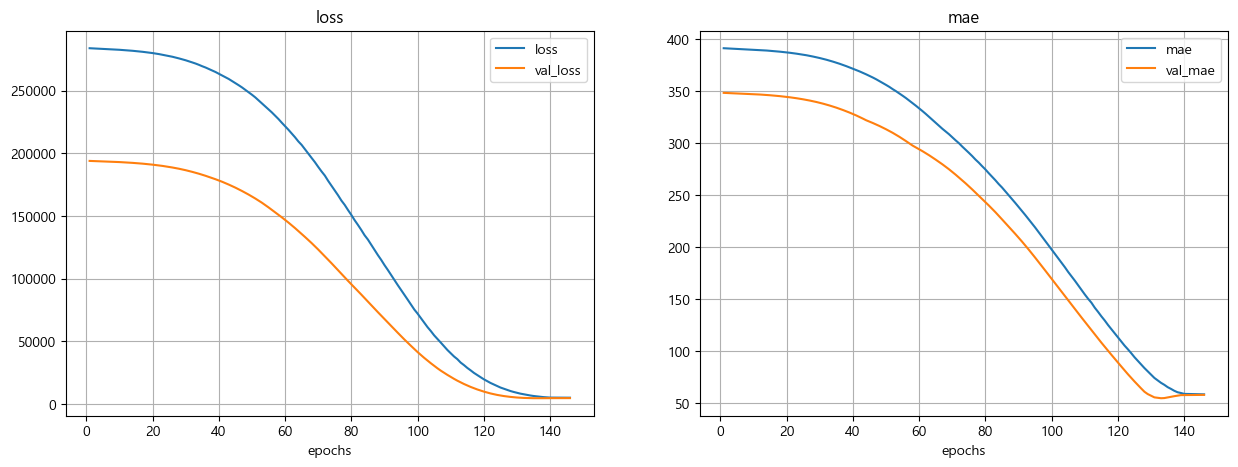

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=100)
result_df.plot(y=['loss', 'val_loss'], ax=ax[0])
result_df.plot(y=['mae', 'val_mae'], ax=ax[1])
ax[0].set_title('loss')
ax[1].set_title('mae')
ax[0].grid()
ax[1].grid()
plt.show()
plt.close()

## #04. 예측 결과 활용

### [1] 예측치 구하기

In [9]:
pred = model.predict(x_test, verbose=1)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[699.4063 ],
       [171.66565],
       [717.7926 ],
       [ 86.65385],
       [108.68026],
       [142.75888],
       [141.05592],
       [664.07495],
       [900.31287],
       [267.94705],
       [126.54   ],
       [105.90073]], dtype=float32)

### [2] 결과 데이터 셋 구성

In [10]:
kdf = DataFrame({
    '길이': x_test['길이'],
    '실제값': y_test,
    '예측값': pred.flatten()
})

kdf['오차'] = kdf['실제값'] - kdf['예측값']

my_pretty_table(kdf)
    

+----+------------+----------+----------+----------+
|    |       길이 |   실제값 |   예측값 |     오차 |
|----+------------+----------+----------+----------|
| 45 |    1.20816 |      650 |  699.406 | -49.4063 |
| 33 | -0.0476513 |      250 |  171.666 |  78.3344 |
| 40 |   0.935156 |      685 |  717.793 | -32.7926 |
| 26 |  -0.364334 |      188 |  86.6538 |  101.346 |
| 11 |  -0.757457 |      115 |   108.68 |  6.31974 |
|  2 |   -1.41266 |       40 |  142.759 | -102.759 |
| 32 | -0.0476513 |      265 |  141.056 |  123.944 |
| 43 |   0.989757 |      690 |  664.075 |   25.925 |
| 46 |    1.20816 |      820 |  900.313 | -80.3129 |
| 30 | -0.0694914 |      300 |  267.947 |  32.0529 |
|  4 |   -1.15058 |       70 |   126.54 |   -56.54 |
| 10 |  -0.757457 |      110 |  105.901 |  4.09927 |
+----+------------+----------+----------+----------+


### [3] 관측치와 예측치 비교 시각화

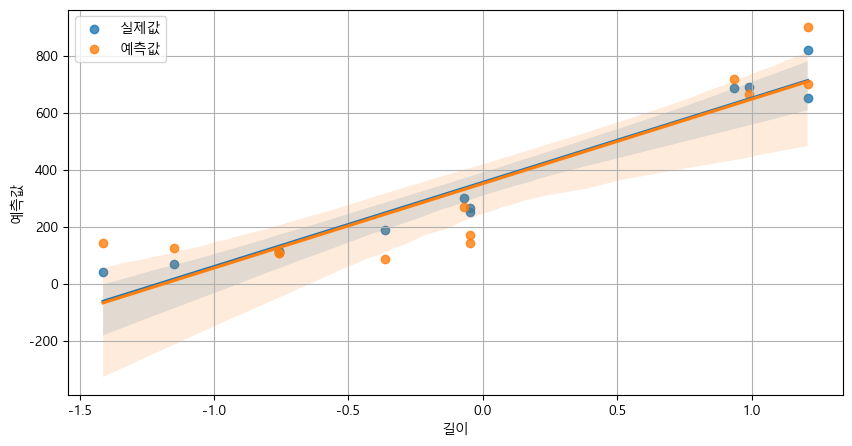

In [11]:
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.gca()

sb.regplot(data=kdf, x='길이', y='실제값', label='실제값', ax=ax)
sb.regplot(data=kdf, x='길이', y='예측값', label='예측값', ax=ax)
ax.legend()
ax.grid()
plt.show()
plt.close()